In [2]:
import copernicusmarine
import xarray as xr
import pandas as pd
import numpy as np
import os

/home/eoserver/miniconda3/envs/obssea4clim/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# copernicusmarine.subset(
#   dataset_id="cmems_mod_glo_phy_my_0.083deg_P1D-m",
#   variables=["thetao"],
#   minimum_longitude=-90,
#   maximum_longitude=70,
#   minimum_latitude=10,
#   maximum_latitude=80,
#   start_datetime="1993-01-01T00:00:00",
#   end_datetime="1993-12-31T00:00:00",
#   minimum_depth=0.49402499198913574,
#   maximum_depth=5727.9169921875,
# )

In [ ]:
# Define parameters
dataset_id = "cmems_mod_glo_phy_my_0.083deg_P1D-m"
variables = ["thetao"]
min_lon, max_lon = -90, 70
min_lat, max_lat = 10, 80
min_depth, max_depth = 0.49402499198913574, 5727.9169921875
output_folder = "processed_data"
os.makedirs(output_folder, exist_ok=True)

# Set the time range
start_year = 2018#1993
end_year = 2019#2024  # Update as needed
months_per_batch = 1  # Change this to set the interval (e.g., 4 or 5 months at a time)

# Function to downscale data to 0.25° resolution
def interp_to_025deg(ds):
    """Downscale an xarray dataset to 0.25° resolution using linear interpolation."""
    new_lat = np.arange(ds.latitude.min(), ds.latitude.max(), 0.25)
    new_lon = np.arange(ds.longitude.min(), ds.longitude.max(), 0.25)
    ds_resampled = ds.interp(latitude=new_lat, longitude=new_lon, method="linear")
    return ds_resampled

factor = int(round(0.25 / 0.083))
def coarsen_to_025deg(ds):
    """Downscale an xarray dataset to 0.25° resolution using coarsening."""
    ds_resampled = ds.coarsen(latitude=factor, longitude=factor, boundary="trim").mean()
    return ds_resampled

# Generate a list of time intervals
date_ranges = pd.date_range(start=f"{start_year}-01-01", end=f"{end_year}-12-31", freq=f"{months_per_batch}MS")

In [ ]:
# Loop through each time interval
for i in range(len(date_ranges) - 1):
    start_date = date_ranges[i].strftime("%Y-%m-%dT00:00:00")
    end_date = date_ranges[i + 1] - pd.Timedelta(days=1)  # Last day of the interval
    end_date = end_date.strftime("%Y-%m-%dT00:00:00")

    print(f"Downloading data from {start_date} to {end_date}...")

    # Define file names
    nc_file = f"{output_folder}/thetao_{start_date[:7]}_to_{end_date[:7]}.nc"
    downscaled_file = f"{output_folder}/thetao_{start_date[:7]}_to_{end_date[:7]}_025deg.nc"

    try:
        # Download the data
        copernicusmarine.subset(
            dataset_id=dataset_id,
            variables=variables,
            minimum_longitude=min_lon,
            maximum_longitude=max_lon,
            minimum_latitude=min_lat,
            maximum_latitude=max_lat,
            start_datetime=start_date,
            end_datetime=end_date,
            minimum_depth=min_depth,
            maximum_depth=max_depth,
            output_filename=nc_file
        )

        # Open and process the dataset
        print(f"Processing data from {start_date} to {end_date} (downscaling)...")
        ds = xr.open_dataset(nc_file)

        ds = ds.astype(np.float32)

        # Downscale to 0.25° resolution
        ds_downscaled = coarsen_to_025deg(ds)

        # Save the downscaled dataset
        ds_downscaled.to_netcdf(downscaled_file)
        print(f"Downscaled data saved: {downscaled_file}")

        # Close datasets to free memory
        ds.close()
        ds_downscaled.close()

        # Delete the original file
        os.remove(nc_file)
        print(f"Deleted original file: {nc_file}")

    except Exception as e:
        print(f"Error processing data from {start_date} to {end_date}: {e}")
        print("Skipping this interval and moving to the next.")

    print(f"Moving to next interval...\n")

print("All intervals processed successfully.")

WARNING - 2025-03-18T10:04:06Z - The following hosts are deprecated and will be removed in future versions: ['nrt.cmems-du.eu', 'my.cmems-du.eu']. Please update your netrc file to use the new authentication system domain: auth.marine.copernicus.eu.
INFO - 2025-03-18T10:04:07Z - Selected dataset version: "202311"
INFO - 2025-03-18T10:04:07Z - Selected dataset part: "default"
INFO - 2025-03-18T10:04:15Z - Starting download. Please wait...
100%|██████████| 21800/21800 [00:59<00:00, 366.64it/s]
INFO - 2025-03-18T10:05:17Z - Successfully downloaded to processed_data/thetao_2018-12_to_2018-12.nc


Processing data from 2018-12-01T00:00:00 to 2018-12-31T00:00:00 (downscaling)...
Downscaled data saved: processed_data/thetao_2018-12_to_2018-12_025deg.nc
Deleted original file: processed_data/thetao_2018-12_to_2018-12.nc
Moving to next interval...

All intervals processed successfully.


In [ ]:
factor = int(round(0.25 / 0.083))
def coarsen_to_025deg(ds):
    """Downscale an xarray dataset to 0.25° resolution using coarsening."""
    ds_resampled = ds.coarsen(latitude=factor, longitude=factor, boundary="trim").mean()
    return ds_resampled

ds = xr.open_dataset('processed_data/thetao_1993-01_to_1993-06.nc')

# Downscale to 0.25° resolution
ds_downscaled = coarsen_to_025deg(ds)
ds_downscaled

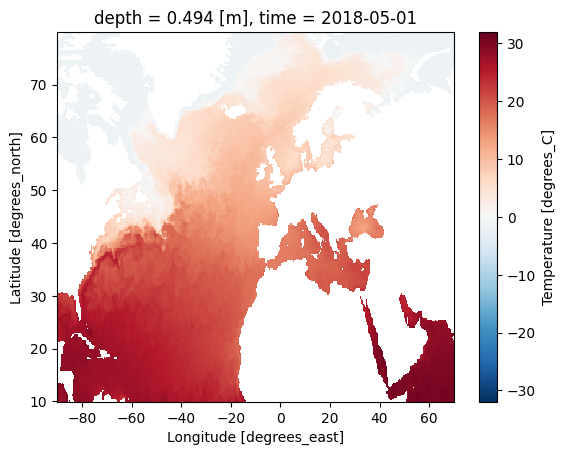

In [6]:
ds_small = xr.open_dataset('processed_data/thetao_2018-05_to_2018-05_025deg.nc')
ds_small.thetao.isel(time=0, depth=0).plot()

In [3]:
ds_small = xr.open_dataset('processed_data/thetao_2018-05_to_2018-05_025deg.nc')
ds_small

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 31, depth: 50, latitude: 280, longitude: 640)
Coordinates:
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 1kB 10.08 10.33 10.58 ... 79.33 79.58 79.83
  * longitude  (longitude) float32 3kB -89.92 -89.67 -89.42 ... 69.58 69.83
  * time       (time) datetime64[ns] 248B 2018-05-01 2018-05-02 ... 2018-05-31
Data variables:
    thetao     (time, depth, latitude, longitude) float64 2GB ...
Attributes:
    Conventions:               CF-1.4
    history:                   2023/06/01 16:20:05 MERCATOR OCEAN Netcdf crea...
    references:                http://www.mercator-ocean.fr
    institution:               MERCATOR OCEAN
    comment:                   CMEMS product
    source:                    MERCATOR GLORYS12V1
    title:                     daily mean fields from Global Ocean Physics An...
    copernicusmarine_version:  2.0.1

In [42]:
d=ds_small.depth.values
d

array([4.940250e-01, 1.541375e+00, 2.645669e+00, 3.819495e+00,
       5.078224e+00, 6.440614e+00, 7.929560e+00, 9.572997e+00,
       1.140500e+01, 1.346714e+01, 1.581007e+01, 1.849556e+01,
       2.159882e+01, 2.521141e+01, 2.944473e+01, 3.443415e+01,
       4.034405e+01, 4.737369e+01, 5.576429e+01, 6.580727e+01,
       7.785385e+01, 9.232607e+01, 1.097293e+02, 1.306660e+02,
       1.558507e+02, 1.861256e+02, 2.224752e+02, 2.660403e+02,
       3.181274e+02, 3.802130e+02, 4.539377e+02, 5.410889e+02,
       6.435668e+02, 7.633331e+02, 9.023393e+02, 1.062440e+03,
       1.245291e+03, 1.452251e+03, 1.684284e+03, 1.941893e+03,
       2.225078e+03, 2.533336e+03, 2.865703e+03, 3.220820e+03,
       3.597032e+03, 3.992484e+03, 4.405224e+03, 4.833291e+03,
       5.274784e+03, 5.727917e+03], dtype=float32)

In [40]:
n=48
d[n+1]-d[n]

453.1328

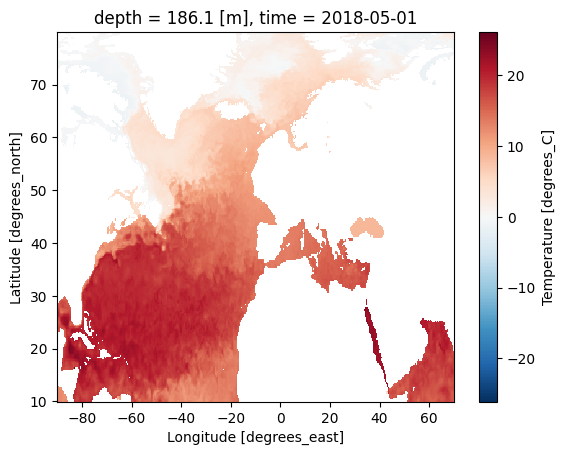

In [23]:
ds_small.thetao.isel(time=0, depth=25).plot()

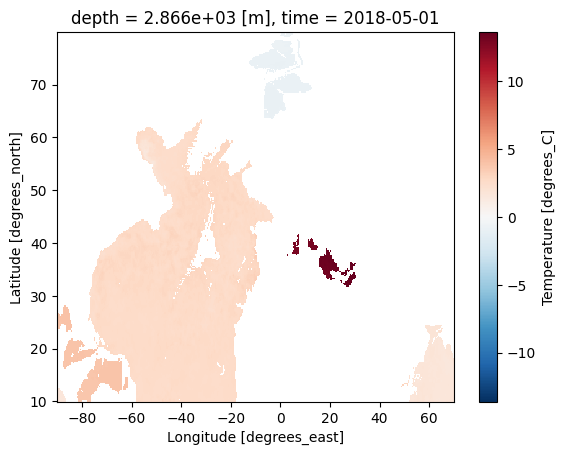

In [46]:
ds_small.thetao.isel(time=0, depth=-8).plot()

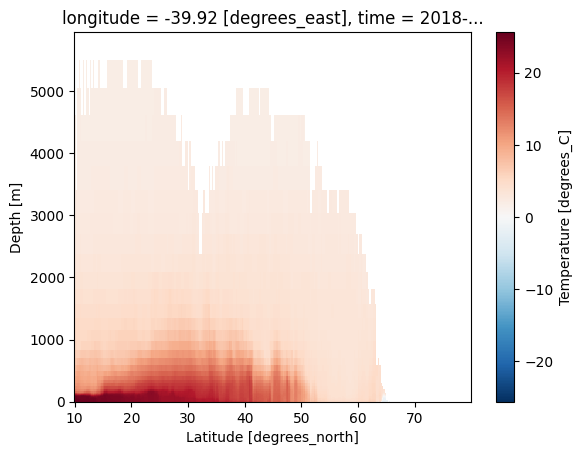

In [29]:
ds_small.thetao.sel(time='2018-05-01', longitude=-40, method='nearest').plot()